# IMU noise characterization using Allan deviation

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Few notes:


In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_xUp.csv'

# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_30mn_gyrocalSR400_acclinSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zDown.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR100_accSR125.csv' 
CSV_FILENAME = HOME+'/Data/Drones/IMU/oak_BNO086_60mn_gyroSR400_accSR500_xDown.csv'
FS = 400  # Sample rate [Hz] # this is obtained from the measured data
ANGLE_UNIT_FOR_NOISE = 'rad' # or 'deg'
VELOCITY_UNIT_FOR_NOISE = 'm/s' # or e.g. 'cm/s'
ACCELERATION_UNIT_FOR_NOISE = 'm/s²' # or 'g'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram
LOAD_SAMPLE = 'all'

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def fitfunc(x, a, b):
    return a*x + b


In [4]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [5]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [6]:
if ANGLE_UNIT_FOR_NOISE == 'deg':
    gx = gx * (180.0 / np.pi)  # [deg/s]
    gy = gy * (180.0 / np.pi)
    gz = gz * (180.0 / np.pi)


In [7]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 1440000


In [7]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    """Compute the Allan deviation (sigma) of time-series data.

    Algorithm obtained from Mathworks:
    https://www.mathworks.com/help/fusion/ug/inertial-sensor-noise-analysis-using-allan-variance.html

    Args
    ----
        dataArr: 1D data array
        fs: Data sample frequency in Hz
        maxNumM: Number of output points

    Returns
    -------
        (taus, allanDev): Tuple of results
        taus (numpy.ndarray): Array of tau values
        allanDev (numpy.ndarray): Array of computed Allan deviations
    """
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )

    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))



In [32]:
# Calculate gyro angles
DRIFT_TIME = 60 # time over which to observe the drift, seconds
NB_SAMPLE = DRIFT_TIME * FS
t_drift = np.arange(0,60,TS)
print(t_drift,len(t_drift))
print(NB_SAMPLE)
NB_DRIFT_OBSERVATION = 30
thetax = np.zeros((NB_DRIFT_OBSERVATION,NB_SAMPLE))
for i in range(NB_DRIFT_OBSERVATION):
    thetax[i] = np.cumsum(gx[10000*i:10000*i+NB_SAMPLE]) * TS  # 
    # thetax[i] = np.cumsum(gx[i*i:i*i+NB_SAMPLE]) * TS  # deg or rad depending on ANGLE_UNIT_FOR_NOISE
# thetay = np.cumsum(gy) * TS
# thetaz = np.cumsum(gz) * TS
print(thetax[0])


[0.00000e+00 2.50000e-03 5.00000e-03 ... 5.99925e+01 5.99950e+01
 5.99975e+01] 24000
24000
[-2.66325000e-05 -4.79375000e-05 -5.59275000e-05 ...  3.72950975e-02
  3.72737925e-02  3.72658025e-02]


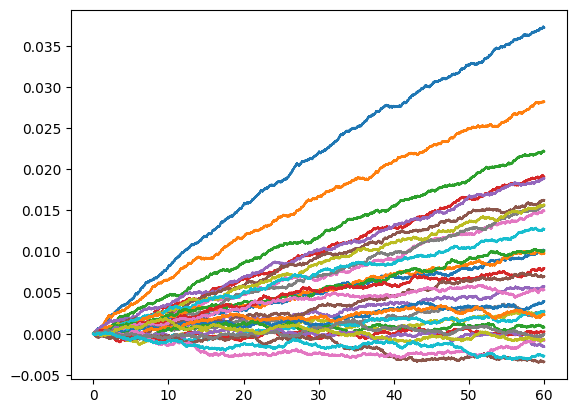

In [33]:
plt.figure()
for i in range(NB_DRIFT_OBSERVATION):
    plt.plot(t_drift,thetax[i])

linear -0.5 slope for gx: = (29, 110)
linear -0.5 slope for gy: = (18, 100)
linear -0.5 slope for gz: = (21, 100)
popt_cons = [-0.50000021 -8.37303556]
[-0.49975657 -8.37310822] [-0.50882927 -8.6139065 ] [-0.50504586 -8.50046374]
gyro_angle_randwalk_x: from linear fit 2.31e-04,from -0.5 slope fit: 2.31e-04
gyro_angle_randwalk_y = 1.82e-04
gyro_angle_randwalk_z = 2.03e-04
Average gyro_angle_randwalk = 2.05e-04 rad/√s or 0.71 °/√hr (deg/sqrt(hour))
linear fit slope for gx: = (135, 168)
linear fit slope for gy: = (135, 168)
linear fit slope for gz: = (135, 168)
[  0.14690915 -10.9603069 ] [  0.31102896 -11.87074736] [-0.26971711 -9.66142046]
local min: 159, scale_fact = 0.6642824702679601
Bias instability in x: 3.08e-05rad/s
Bias instability in y: 1.75e-05rad/s
Bias instability in z: 6.53e-06rad/s
Average bias instability = 1.83e-05 rad/s 3.8 deg/hr
gyro_rate_randwalk_x = 2.04e-05 rad/s/√s
gyro_rate_randwalk_y = 9.84e-06 rad/s/√s
gyro_rate_randwalk_z = 4.74e-05 rad/s/√s
Average gyro_rate_

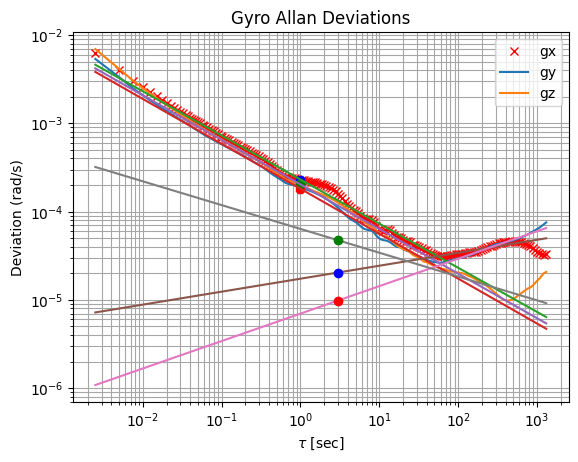

In [41]:
# Plot data on log-scale
plt.figure()
plt.title('Gyro Allan Deviations')
plt.plot(taux, adx, 'rx', label='gx')
# plt.plot(taux, adx, 'rx', label='gx') # to see the points
plt.plot(tauy, ady, label='gy')
plt.plot(tauz, adz, label='gz')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel(f'Deviation ({ANGLE_UNIT_FOR_NOISE}/s)')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.show()
# find angle random walk, intersection of random walk line fit (-0.5 slope)
# at tau = 1
# add curve fit to proper section of curve
# that is, between  10^-1 < tau < 20 for the gx component for one of the OAK-D
# Location for the other components (gy, gz) is likely (slightly) different
# get the corresponding indexes (manual work, could do auto)
idx_start = np.where(taux < 0.1)[0][-1]
idx_end = np.where(taux > 20)[0][0]
print(f'linear -0.5 slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy < 0.05)[0][-1]
idx_end = np.where(tauy > 10)[0][0]
print(f'linear -0.5 slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz < 0.06)[0][-1]
idx_end = np.where(tauz > 10)[0][0]
print(f'linear -0.5 slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])
#####
# below we do 2 different fits: one with fixed -0.5 slope, the other computes the slope (linear fit)
# fix the slope for the linear fit
#####
UP_BOUND_SLOPE = -0.5
LO_BOUND_SLOPE = -0.5001
popt_cons, _ = curve_fit(fitfunc, logtaux,logadx, bounds=([LO_BOUND_SLOPE,-np.inf],
                                                          [UP_BOUND_SLOPE,np.inf]))
print(f'popt_cons = {popt_cons}')
# compute the slope
coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
# random walk fit
rw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
# -0.5 slope line fit to random walk
fixpoly_x = np.poly1d(popt_cons)
#fixpoly_y = np.poly1d(coeffs_y)
#fixpoly_z = np.poly1d(coeffs_z)
rw_fixfit_x = lambda taux: np.exp(fixpoly_x(np.log(taux)))
#rw_fixfit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
#rw_fixfit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))

# angle random walk
# often noted N
# unit rad/s/√Hz or rad/√s or °/√hr for a more palpable unit
gyro_angle_randwalk_x = rw_fit_x(1)
gyro_angle_randwalk_x_fixfit = rw_fixfit_x(1)
gyro_angle_randwalk_y = rw_fit_y(1)
gyro_angle_randwalk_z = rw_fit_z(1)
gyro_angle_randwalk_avg = (gyro_angle_randwalk_x
                           + gyro_angle_randwalk_y
                           + gyro_angle_randwalk_z) / 3.0
gyro_angle_randwalk_avg_dph = 60 * gyro_angle_randwalk_avg * RAD_2_DEG
print((f'gyro_angle_randwalk_x: from linear fit '
      f'{gyro_angle_randwalk_x:.{PRECI}{TYPE}},'
      f'from -0.5 slope fit: {gyro_angle_randwalk_x_fixfit:.{PRECI}{TYPE}}'))
print(f'gyro_angle_randwalk_y = {gyro_angle_randwalk_y:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_z = {gyro_angle_randwalk_z:.{PRECI}{TYPE}}')
print(f'Average gyro_angle_randwalk = '
      f'{gyro_angle_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/√s'
      f' or {gyro_angle_randwalk_avg_dph:.{PRECI:g}} °/√hr (deg/sqrt(hour))')
      #f' or {gyro_angle_randwalk_avg_dph:.{PRECI}{TYPE}} °/√hr (deg/sqrt(hour))')
#print(f'Sqrt Average gyro_angle_randwalk \
    #= {np.sqrt(gyro_angle_randwalk_avg):.{PRECI}{TYPE}}')
plt.plot(1,gyro_angle_randwalk_x,'b8')
plt.plot(1,gyro_angle_randwalk_y,'r8')
plt.plot(1,gyro_angle_randwalk_z,'g8')
plt.plot(taux,rw_fit_x(taux))
plt.plot(tauy,rw_fit_y(tauy))
plt.plot(tauz,rw_fit_z(tauz))

# get the rate random walk (unit: (rad/s)/√Hz
# fit in the other direction

idx_start = np.where(taux > 100)[0][0]
idx_end = np.where(taux < 1000)[0][-1]
print(f'linear fit slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy > 100)[0][0]
idx_end = np.where(tauy < 1000)[0][-1]
print(f'linear fit slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz > 100)[0][0]
idx_end = np.where(tauz < 1000)[0][-1]
print(f'linear fit slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])

coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit = lambda x: poly_x(taux)
rrw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rrw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rrw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
plt.plot(taux,rrw_fit_x(taux))
plt.plot(tauy,rrw_fit_y(tauy))
plt.plot(tauz,rrw_fit_z(tauz))
#plt.plot(tauz,yfit_z(tauz))
#################
# Bias instability
# not used in Kalibr 
#################
# compute derivative of Allan curve and intersect with line of slope 0

deriv_x = np.gradient(adx,taux)
deriv_y = np.gradient(ady,tauy)
deriv_z = np.gradient(adz,tauz)
local_min_x = np.argmin(np.abs(deriv_x))
local_min_y = np.argmin(np.abs(deriv_y))
local_min_z = np.argmin(np.abs(deriv_z))
scale_fact = np.sqrt(2*np.log(2)/np.pi)
bias_instab_x =adx[local_min_x] * scale_fact
bias_instab_y =ady[local_min_y] * scale_fact
bias_instab_z =adz[local_min_z] * scale_fact
gyro_bias_instab_avg = (bias_instab_x + bias_instab_y + bias_instab_z)/3.0
gyro_bias_instab_avg_dph = 3600 * gyro_bias_instab_avg * RAD_2_DEG
print(f'local min: {np.argmin(np.abs(deriv_x))}, scale_fact = {scale_fact}')
print(f'Bias instability in x: {bias_instab_x:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Bias instability in y: {bias_instab_y:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Bias instability in z: {bias_instab_z:.{PRECI}{TYPE}}{ANGLE_UNIT_FOR_NOISE}/s')
print(f'Average bias instability = '
    f'{gyro_bias_instab_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s '
    f'{gyro_bias_instab_avg_dph:.{PRECI}} deg/hr')
#print(f'dev = {logadx(local_min[0])}')

# find K, rate random walk unit (rad/s)*√Hz or (°/s)*√Hz
# gyro "random walk" in Kalibr
#, intersection of random walk line fit
# at tau = 3
# print(f'poly_z = {poly_z}')
# print(f'rrw_fit_z(1)= {rrw_fit_z(1)}')
gyro_rate_randwalk_x = rrw_fit_x(3)
gyro_rate_randwalk_y = rrw_fit_y(3)
gyro_rate_randwalk_z = rrw_fit_z(3)
gyro_rate_randwalk_avg = (gyro_rate_randwalk_x + gyro_rate_randwalk_y + gyro_rate_randwalk_z)/3.0
gyro_rate_randwalk_rms = np.sqrt((gyro_rate_randwalk_x*gyro_rate_randwalk_x 
                                  + gyro_rate_randwalk_y*gyro_rate_randwalk_y 
                                  + gyro_rate_randwalk_z*gyro_rate_randwalk_z))

print(f'gyro_rate_randwalk_x = {gyro_rate_randwalk_x:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_y = {gyro_rate_randwalk_y:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_z = {gyro_rate_randwalk_z:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'Average gyro_rate_randwalk = {gyro_rate_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'RMS gyro_rate_randwalk (Kg)= {gyro_rate_randwalk_rms:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

plt.plot(3,gyro_rate_randwalk_x,'bo')
plt.plot(3,gyro_rate_randwalk_y,'ro')
plt.plot(3,gyro_rate_randwalk_z,'go')
plt.show()


In [42]:
# Calculate velocity
velx = np.cumsum(accx) * TS  # deg or rad depending on ANGLE_UNIT_FOR_NOISE
vely = np.cumsum(accy) * TS
velz = np.cumsum(accz) * TS

# Compute Allan deviations
Mnb = 200 # for noise analysis
(taux, adx) = AllanDeviation(velx, FS, maxNumM=Mnb)
(tauy, ady) = AllanDeviation(vely, FS, maxNumM=Mnb)
(tauz, adz) = AllanDeviation(velz, FS, maxNumM=Mnb)


## Accelerometer

linear -0.5 slope for gx: = (29, 110)
linear -0.5 slope for gy: = (18, 100)
linear -0.5 slope for gz: = (21, 100)
popt_cons = [-0.5        -6.53656468]
[-0.37101912 -6.57503136] [-0.47724132 -6.85463411] [-0.44039993 -6.49051216]
accel_veloci_randwalk_x: from linear fit 1.39e-03,from -0.5 slope fit: 1.45e-03
accel_veloci_randwalk_y = 1.05e-03
accel_veloci_randwalk_z = 1.52e-03
Average accel_veloci_randwalk = 1.32e-03 m/s/√s or 0.079 m/s/√hr (m/s/sqrt(hour))
linear fit slope for gx: = (135, 168)
linear fit slope for gy: = (135, 168)
linear fit slope for gz: = (135, 168)
[ 0.24815198 -7.85658088] [  0.86723956 -10.98580635] [-0.16268728 -6.38826254]
local min: 167, scale_fact = 0.6642824702679601
Bias instability in x: 1.23e-03m/s²
Bias instability in y: 2.73e-04m/s²
Bias instability in z: 5.44e-04m/s²
Average bias instability = 6.81e-04 m/s² 2.5 deg/hr
acceleration_randwalk_x = 5.09e-04 m/s²/√s
acceleration_randwalk_y = 4.39e-05 m/s²/√s
acceleration_randwalk_z = 1.41e-03 m/s²/√s
Average

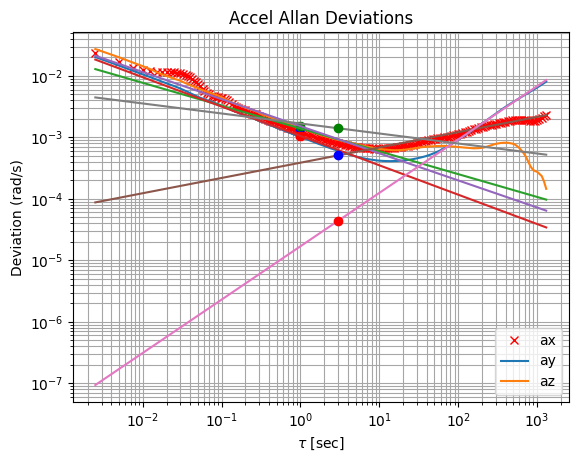

In [43]:
# Plot data on log-scale
plt.figure()
plt.title('Accel Allan Deviations')
plt.plot(taux, adx, 'rx', label='ax')
plt.plot(tauy, ady, label='ay')
plt.plot(tauz, adz, label='az')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel(f'Deviation ({ANGLE_UNIT_FOR_NOISE}/s)')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.show()
# find angle random walk, intersection of random walk line fit (-0.5 slope)
# at tau = 1
# add curve fit to proper section of curve
# that is, between  10^-1 < tau < 20 for the gx component for one of the OAK-D
# Location for the other components (gy, gz) is likely (slightly) different
# get the corresponding indexes (manual work, could do auto)
idx_start = np.where(taux < 0.1)[0][-1]
idx_end = np.where(taux > 20)[0][0]
print(f'linear -0.5 slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy < 0.05)[0][-1]
idx_end = np.where(tauy > 10)[0][0]
print(f'linear -0.5 slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz < 0.06)[0][-1]
idx_end = np.where(tauz > 10)[0][0]
print(f'linear -0.5 slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])
#####
# below we do 2 different fits: one with fixed -0.5 slope, the other computes the slope (linear fit)
# fix the slope for the linear fit
#####
UP_BOUND_SLOPE = -0.5
LO_BOUND_SLOPE = -0.5001
popt_cons, _ = curve_fit(fitfunc, logtaux,logadx, bounds=([LO_BOUND_SLOPE,-np.inf],
                                                          [UP_BOUND_SLOPE,np.inf]))
print(f'popt_cons = {popt_cons}')
# compute the slope
coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
# random walk fit
rw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
# -0.5 slope line fit to random walk
fixpoly_x = np.poly1d(popt_cons)
#fixpoly_y = np.poly1d(coeffs_y)
#fixpoly_z = np.poly1d(coeffs_z)
rw_fixfit_x = lambda taux: np.exp(fixpoly_x(np.log(taux)))
#rw_fixfit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
#rw_fixfit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))

# velocity random walk
# noted Na or σa, 
# unit m/s²/√Hz or (m/s)/√s or (m/s)√Hz, or (m/s)/√hr for a more palpable unit
accel_veloci_randwalk_x = rw_fit_x(1)
accel_veloci_randwalk_x_fixfit = rw_fixfit_x(1)
accel_veloci_randwalk_y = rw_fit_y(1)
accel_veloci_randwalk_z = rw_fit_z(1)
accel_veloci_randwalk_avg = (accel_veloci_randwalk_x
                           + accel_veloci_randwalk_y
                           + accel_veloci_randwalk_z) / 3.0
accel_veloci_randwalk_avg_dph = 60 * accel_veloci_randwalk_avg
print((f'accel_veloci_randwalk_x: from linear fit '
      f'{accel_veloci_randwalk_x:.{PRECI}{TYPE}},'
      f'from -0.5 slope fit: {accel_veloci_randwalk_x_fixfit:.{PRECI}{TYPE}}'))
print(f'accel_veloci_randwalk_y = {accel_veloci_randwalk_y:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_z = {accel_veloci_randwalk_z:.{PRECI}{TYPE}}')
print(f'Average accel_veloci_randwalk = '
      f'{accel_veloci_randwalk_avg:.{PRECI}{TYPE}} {VELOCITY_UNIT_FOR_NOISE}/√s'
      f' or {accel_veloci_randwalk_avg_dph:.{PRECI:g}} {VELOCITY_UNIT_FOR_NOISE}/√hr (m/s/sqrt(hour))')
      #f' or {accel_veloci_randwalk_avg_dph:.{PRECI}{TYPE}} °/√hr (deg/sqrt(hour))')
#print(f'Sqrt Average accel_veloci_randwalk \
    #= {np.sqrt(accel_veloci_randwalk_avg):.{PRECI}{TYPE}}')
plt.plot(1,accel_veloci_randwalk_x,'b8')
plt.plot(1,accel_veloci_randwalk_y,'r8')
plt.plot(1,accel_veloci_randwalk_z,'g8')
plt.plot(taux,rw_fit_x(taux))
plt.plot(tauy,rw_fit_y(tauy))
plt.plot(tauz,rw_fit_z(tauz))

# get the rate random walk (unit: (rad/s)/√Hz
# fit in the other direction

idx_start = np.where(taux > 100)[0][0]
idx_end = np.where(taux < 1000)[0][-1]
print(f'linear fit slope for gx: = {idx_start,idx_end}')
logtaux = np.log(taux[idx_start:idx_end])
logadx = np.log(adx[idx_start:idx_end])
# for gy
idx_start = np.where(tauy > 100)[0][0]
idx_end = np.where(tauy < 1000)[0][-1]
print(f'linear fit slope for gy: = {idx_start,idx_end}')
logtauy = np.log(tauy[idx_start:idx_end])
logady = np.log(ady[idx_start:idx_end])
# for gz
idx_start = np.where(tauz > 100)[0][0]
idx_end = np.where(tauz < 1000)[0][-1]
print(f'linear fit slope for gz: = {idx_start,idx_end}')
logtauz = np.log(tauz[idx_start:idx_end])
logadz = np.log(adz[idx_start:idx_end])

coeffs_x = np.polyfit(logtaux,logadx, deg=1)
coeffs_y = np.polyfit(logtauy,logady, deg=1)
coeffs_z = np.polyfit(logtauz,logadz, deg=1)
print(coeffs_x,coeffs_y,coeffs_z)
poly_x = np.poly1d(coeffs_x)
poly_y = np.poly1d(coeffs_y)
poly_z = np.poly1d(coeffs_z)
#yfit = lambda x: poly_x(taux)
rrw_fit_x = lambda taux: np.exp(poly_x(np.log(taux)))
rrw_fit_y = lambda tauy: np.exp(poly_y(np.log(tauy)))
rrw_fit_z = lambda tauz: np.exp(poly_z(np.log(tauz)))
#yfit_x = lambda x: np.exp(poly_x(np.log(taux))) #np.log(x)))
#yfit_y = lambda x: np.exp(poly_y(np.log(tauy))) #np.log(x)))
#yfit_z = lambda x: np.exp(poly_z(np.log(tauz))) #np.log(x)))
plt.plot(taux,rrw_fit_x(taux))
plt.plot(tauy,rrw_fit_y(tauy))
plt.plot(tauz,rrw_fit_z(tauz))
#plt.plot(tauz,yfit_z(tauz))
#################
# Bias instability, Ba
# not used in Kalibr
#################
# compute derivative of Allan curve and intersect with line of slope 0

deriv_x = np.gradient(adx,taux)
deriv_y = np.gradient(ady,tauy)
deriv_z = np.gradient(adz,tauz)
local_min_x = np.argmin(np.abs(deriv_x))
local_min_y = np.argmin(np.abs(deriv_y))
local_min_z = np.argmin(np.abs(deriv_z))
scale_fact = np.sqrt(2*np.log(2)/np.pi)
bias_instab_x =adx[local_min_x] * scale_fact
bias_instab_y =ady[local_min_y] * scale_fact
bias_instab_z =adz[local_min_z] * scale_fact
accel_bias_instab_avg = (bias_instab_x + bias_instab_y + bias_instab_z)/3.0
accel_bias_instab_avg_dph = 3600 * accel_bias_instab_avg
print(f'local min: {np.argmin(np.abs(deriv_x))}, scale_fact = {scale_fact}')
print(f'Bias instability in x: {bias_instab_x:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Bias instability in y: {bias_instab_y:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Bias instability in z: {bias_instab_z:.{PRECI}{TYPE}}{ACCELERATION_UNIT_FOR_NOISE}')
print(f'Average bias instability = '
    f'{accel_bias_instab_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE} '
    f'{accel_bias_instab_avg_dph:.{PRECI}} deg/hr')

# find acceleration random walk unit (m/s²)*√Hz or g*√Hz or (m/s²)/√s or g/√s
# usually noted K
#, intersection of random walk line fit
# at tau = 3
# print(f'poly_z = {poly_z}')
# print(f'rrw_fit_z(1)= {rrw_fit_z(1)}')
acceleration_randwalk_x = rrw_fit_x(3)
acceleration_randwalk_y = rrw_fit_y(3)
acceleration_randwalk_z = rrw_fit_z(3)
acceleration_randwalk_avg = (acceleration_randwalk_x + acceleration_randwalk_y + acceleration_randwalk_z)/3.0
print(f'acceleration_randwalk_x = {acceleration_randwalk_x:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_y = {acceleration_randwalk_y:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_z = {acceleration_randwalk_z:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'Average acceleration_randwalk = {acceleration_randwalk_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
plt.plot(3,acceleration_randwalk_x,'bo')
plt.plot(3,acceleration_randwalk_y,'ro')
plt.plot(3,acceleration_randwalk_z,'go')
plt.show()


## Summary of results

In [56]:
# angle random walk
# often noted N
# unit rad/s/√Hz or rad/√s or °/√hr for a more palpable unit
print(f'accel_veloci_randwalk_x: {accel_veloci_randwalk_x:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_y = {accel_veloci_randwalk_y:.{PRECI}{TYPE}}')
print(f'accel_veloci_randwalk_z = {accel_veloci_randwalk_z:.{PRECI}{TYPE}}')

print(f'acceleration_randwalk_x = {acceleration_randwalk_x:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_y = {acceleration_randwalk_y:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')
print(f'acceleration_randwalk_z = {acceleration_randwalk_z:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')


print(f'gyro_angle_randwalk_x: {gyro_angle_randwalk_x:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_y = {gyro_angle_randwalk_y:.{PRECI}{TYPE}}')
print(f'gyro_angle_randwalk_z = {gyro_angle_randwalk_z:.{PRECI}{TYPE}}')
# K, rate random walk unit (rad/s)*√Hz or (°/s)*√Hz
# gyro "random walk" in Kalibr
print(f'gyro_rate_randwalk_x = {gyro_rate_randwalk_x:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_y = {gyro_rate_randwalk_y:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')
print(f'gyro_rate_randwalk_z = {gyro_rate_randwalk_z:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')




# For VINS, Kalibr, EuRoc....
print(f'\nfor Kalibr: \n')

print(f'Average accel_veloci_randwalk(Na, σba) or noise density = '
      f'{accel_veloci_randwalk_avg:.{PRECI}{TYPE}} {VELOCITY_UNIT_FOR_NOISE}/√s'
      f' or {accel_veloci_randwalk_avg_dph:.{PRECI:g}} {VELOCITY_UNIT_FOR_NOISE}/√hr (m/s/sqrt(hour))')
print(f'Average acceleration_randwalk (Ka, σa)= {acceleration_randwalk_avg:.{PRECI}{TYPE}} {ACCELERATION_UNIT_FOR_NOISE}/√s')

print(f'Average gyro_angle_randwalk (Ng, σbg) or noise density = '
      f'{gyro_angle_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/√s'
      f' or {gyro_angle_randwalk_avg_dph:.{PRECI:g}} °/√hr (deg/sqrt(hour))')
print(f'Average gyro_rate_randwalk  (Kg, σg) = {gyro_rate_randwalk_avg:.{PRECI}{TYPE}} {ANGLE_UNIT_FOR_NOISE}/s/√s')

print(f'\nfor VINS (15x the above results): \n')
acc_n = 15 * accel_veloci_randwalk_avg
gyr_n = 15 * gyro_angle_randwalk_avg
acc_w = 15 * acceleration_randwalk_avg
gyr_w = 15 * gyro_rate_randwalk_avg
print(f'acc_n: {acc_n:.4f}')
print(f'gyr_n: {gyr_n:.4f}')
print(f'acc_w: {acc_w:.4f}')
print(f'gyr_n: {gyr_w:.4f}')

accel_veloci_randwalk_x: 1.39e-03
accel_veloci_randwalk_y = 1.05e-03
accel_veloci_randwalk_z = 1.52e-03
acceleration_randwalk_x = 5.09e-04 m/s²/√s
acceleration_randwalk_y = 4.39e-05 m/s²/√s
acceleration_randwalk_z = 1.41e-03 m/s²/√s
gyro_angle_randwalk_x: 2.31e-04
gyro_angle_randwalk_y = 1.82e-04
gyro_angle_randwalk_z = 2.03e-04
gyro_rate_randwalk_x = 2.04e-05 rad/s/√s
gyro_rate_randwalk_y = 9.84e-06 rad/s/√s
gyro_rate_randwalk_z = 4.74e-05 rad/s/√s

for Kalibr: 

Average accel_veloci_randwalk(Na, σba) or noise density = 1.32e-03 m/s/√s or 0.079 m/s/√hr (m/s/sqrt(hour))
Average acceleration_randwalk (Ka, σa)= 6.53e-04 m/s²/√s
Average gyro_angle_randwalk (Ng, σbg) or noise density = 2.05e-04 rad/√s or 0.71 °/√hr (deg/sqrt(hour))
Average gyro_rate_randwalk  (Kg, σg) = 2.59e-05 rad/s/√s

for VINS (15x the above results): 

acc_n: 0.0198
gyr_n: 0.0031
acc_w: 0.0098
gyr_n: 0.0004
